In [ ]:
import numpy as np

dec_data = np.loadtxt('Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_data.shape)
print(dec_train.shape)
print(dec_val.shape)
print(dec_test.shape)

(149, 254750)
(149, 203800)
(149, 50950)
(149, 139587)


In [ ]:
# load packages
import pandas as pd
import pickle
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers import LeakyReLU
# from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
# from keras.utils import np_utils

from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# set random seeds
np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k] - 1
    y = to_categorical(y, 3)
    return x, y

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Calculate attention scores
        e = tf.keras.backend.dot(x, self.W)

        # Calculate attention weights using softmax activation
        a = tf.keras.activations.softmax(e, axis=-2)

        # Apply attention weights to the input sequence
        output = x * a

        # Sum the weighted inputs to get the attention output
        output = tf.keras.backend.sum(output, axis=-2)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape


In [ ]:
k = 4 # which prediction horizon
T = 100 # the length of a single input i. e lookback_timestep
n_hiddens = 64
checkpoint_filepath = 'path_to_your_10Amodel_checkpoints'
# checkpoint_filepath = './model_tensorflow2/weights'

In [ ]:
# Training Dataset Shrinking
print(dec_train.shape)
trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
print(trainX_CNN.shape, trainY_CNN.shape)

(149, 203800)
(203701, 100, 40, 1) (203701, 3)


In [ ]:
# Testing Dataset Shrinking
print(dec_test.shape)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)
print(testX_CNN.shape, testY_CNN.shape)

(149, 139587)
(139488, 100, 40, 1) (139488, 3)


In [ ]:

# Validation Dataset Shrinking

print(dec_val.shape)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
print(valX_CNN.shape, valY_CNN.shape)

(149, 50950)
(50851, 100, 40, 1) (50851, 3)


In [ ]:
print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(203701, 100, 40, 1) (203701, 3)
(50851, 100, 40, 1) (50851, 3)
(139488, 100, 40, 1) (139488, 3)


In [ ]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))

    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)

    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.2, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm, return_sequences=True)(conv_reshape)

    # add an attention layer
    attention_output = AttentionLayer()(conv_lstm)

    # build the output layer
    out = Dense(3, activation='softmax')(attention_output)

    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

deeplob = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
deeplob.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 100, 20, 32)  96          ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu_14 (LeakyReLU)     (None, 100, 20, 32)  0           ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_15 (Conv2D)             (None, 100, 20, 32)  4128        ['leaky_re_lu_14[0][0]']   

In [ ]:
%%time

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN),
            epochs=200, batch_size=128, verbose=2, callbacks=[model_checkpoint_callback])

Epoch 1/200
1592/1592 - 1803s - loss: 1.0271 - accuracy: 0.4156 - val_loss: 1.0883 - val_accuracy: 0.3723 - 1803s/epoch - 1s/step
Epoch 2/200
1592/1592 - 1567s - loss: 1.0160 - accuracy: 0.4222 - val_loss: 1.0892 - val_accuracy: 0.3727 - 1567s/epoch - 984ms/step
Epoch 3/200
1592/1592 - 1313s - loss: 1.0074 - accuracy: 0.4319 - val_loss: 1.0854 - val_accuracy: 0.3752 - 1313s/epoch - 825ms/step
Epoch 4/200
1592/1592 - 1304s - loss: 0.9996 - accuracy: 0.4396 - val_loss: 1.0841 - val_accuracy: 0.3780 - 1304s/epoch - 819ms/step
Epoch 5/200
1592/1592 - 1307s - loss: 0.9864 - accuracy: 0.4530 - val_loss: 1.0762 - val_accuracy: 0.3849 - 1307s/epoch - 821ms/step
Epoch 6/200
1592/1592 - 1308s - loss: 0.9691 - accuracy: 0.4685 - val_loss: 1.0715 - val_accuracy: 0.3918 - 1308s/epoch - 822ms/step
Epoch 7/200
1592/1592 - 1311s - loss: 0.9366 - accuracy: 0.4977 - val_loss: 1.0467 - val_accuracy: 0.4196 - 1311s/epoch - 824ms/step
Epoch 8/200
1592/1592 - 1304s - loss: 0.8729 - accuracy: 0.5494 - val_lo

Epoch 63/200
1592/1592 - 1313s - loss: 0.3532 - accuracy: 0.8698 - val_loss: 0.9374 - val_accuracy: 0.6622 - 1313s/epoch - 825ms/step
Epoch 64/200
1592/1592 - 1314s - loss: 0.3533 - accuracy: 0.8706 - val_loss: 0.9042 - val_accuracy: 0.6627 - 1314s/epoch - 825ms/step
Epoch 65/200
1592/1592 - 1312s - loss: 0.3491 - accuracy: 0.8717 - val_loss: 0.9581 - val_accuracy: 0.6588 - 1312s/epoch - 824ms/step
Epoch 66/200
1592/1592 - 1316s - loss: 0.3480 - accuracy: 0.8726 - val_loss: 0.9598 - val_accuracy: 0.6566 - 1316s/epoch - 827ms/step
Epoch 67/200
1592/1592 - 1314s - loss: 0.3444 - accuracy: 0.8731 - val_loss: 0.9838 - val_accuracy: 0.6570 - 1314s/epoch - 825ms/step
Epoch 68/200
1592/1592 - 1316s - loss: 0.3421 - accuracy: 0.8743 - val_loss: 0.9735 - val_accuracy: 0.6579 - 1316s/epoch - 827ms/step
Epoch 69/200
1592/1592 - 1317s - loss: 0.3403 - accuracy: 0.8751 - val_loss: 0.9793 - val_accuracy: 0.6570 - 1317s/epoch - 827ms/step
Epoch 70/200
1592/1592 - 1316s - loss: 0.3389 - accuracy: 0.87

Epoch 124/200
1592/1592 - 1320s - loss: 0.2537 - accuracy: 0.9077 - val_loss: 1.1955 - val_accuracy: 0.6402 - 1320s/epoch - 829ms/step
Epoch 125/200
1592/1592 - 1328s - loss: 0.2516 - accuracy: 0.9084 - val_loss: 1.2237 - val_accuracy: 0.6387 - 1328s/epoch - 834ms/step
Epoch 126/200
1592/1592 - 1323s - loss: 0.2531 - accuracy: 0.9079 - val_loss: 1.2354 - val_accuracy: 0.6366 - 1323s/epoch - 831ms/step
Epoch 127/200
1592/1592 - 1326s - loss: 0.2496 - accuracy: 0.9099 - val_loss: 1.2329 - val_accuracy: 0.6404 - 1326s/epoch - 833ms/step
Epoch 128/200
1592/1592 - 1321s - loss: 0.2491 - accuracy: 0.9093 - val_loss: 1.2420 - val_accuracy: 0.6410 - 1321s/epoch - 830ms/step
Epoch 129/200
1592/1592 - 1322s - loss: 0.2480 - accuracy: 0.9102 - val_loss: 1.2109 - val_accuracy: 0.6404 - 1322s/epoch - 830ms/step
Epoch 130/200
1592/1592 - 1320s - loss: 0.2470 - accuracy: 0.9096 - val_loss: 1.1969 - val_accuracy: 0.6419 - 1320s/epoch - 829ms/step
Epoch 131/200
1592/1592 - 1322s - loss: 0.2470 - accura

Epoch 185/200
1592/1592 - 1318s - loss: 0.2008 - accuracy: 0.9262 - val_loss: 1.3855 - val_accuracy: 0.6321 - 1318s/epoch - 828ms/step
Epoch 186/200
1592/1592 - 1319s - loss: 0.1983 - accuracy: 0.9278 - val_loss: 1.3671 - val_accuracy: 0.6282 - 1319s/epoch - 829ms/step
Epoch 187/200
1592/1592 - 1316s - loss: 0.1993 - accuracy: 0.9269 - val_loss: 1.4096 - val_accuracy: 0.6280 - 1316s/epoch - 827ms/step
Epoch 188/200
1592/1592 - 1315s - loss: 0.1986 - accuracy: 0.9273 - val_loss: 1.4020 - val_accuracy: 0.6274 - 1315s/epoch - 826ms/step
Epoch 189/200
1592/1592 - 1318s - loss: 0.1977 - accuracy: 0.9277 - val_loss: 1.4177 - val_accuracy: 0.6345 - 1318s/epoch - 828ms/step
Epoch 190/200
1592/1592 - 1318s - loss: 0.1967 - accuracy: 0.9282 - val_loss: 1.4519 - val_accuracy: 0.6285 - 1318s/epoch - 828ms/step
Epoch 191/200
1592/1592 - 1313s - loss: 0.1958 - accuracy: 0.9282 - val_loss: 1.4354 - val_accuracy: 0.6338 - 1313s/epoch - 825ms/step
Epoch 192/200
1592/1592 - 1317s - loss: 0.1970 - accura

In [ ]:
deeplob.load_weights(checkpoint_filepath)
pred = deeplob.predict(testX_CNN)

4359/4359 [==============================] - 155s 34ms/step


In [ ]:
print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))

accuracy_score: 0.7441715416379904
              precision    recall  f1-score   support

           0     0.7198    0.7478    0.7335     47915
           1     0.8253    0.7401    0.7804     48050
           2     0.6951    0.7447    0.7191     43523

    accuracy                         0.7442    139488
   macro avg     0.7468    0.7442    0.7443    139488
weighted avg     0.7485    0.7442    0.7452    139488



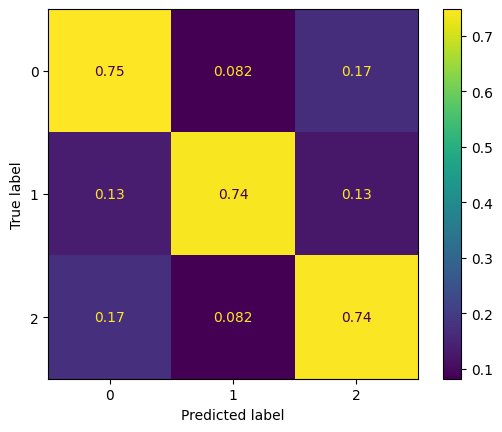

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
c = confusion_matrix(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()